# Sparse matrices

In [1]:
import numpy as np
import scipy.sparse as sps
from matplotlib import pyplot as plt
from scipy.sparse.linalg import LinearOperator
import numba
import time
from timeit import timeit
from scipy.sparse.linalg import cg
from scipy.sparse.linalg import gmres
%matplotlib inline

## Part 1

Scipy allows you to define your own objects that can be used with their sparse solvers. This is my version of a CSR matrix format to use with the Scipy solvers.

In [2]:
class CSRMatrix(LinearOperator):
    def __init__(self, coo_matrix):
        self.shape = coo_matrix.shape
        self.dtype = coo_matrix.dtype
        
        if len(coo_matrix.data) == 0:
            print('Error: no data in matrix')
            return
        
        lst = sorted(list(zip(coo_matrix.row, coo_matrix.col, coo_matrix.data)), # sorting by rows and columns
                     key = lambda entry: (entry[0], entry[1]))
        coo_sorted = list(zip(*lst)) # unzipping back into three lists of rows, cols, data
        
        # compute indptr
        counts = np.bincount(coo_sorted[0])
        indptr = np.zeros(self.shape[0]+1, dtype=int)
        for i in range(self.shape[0]+1):
            indptr[i] = np.sum(counts[:i])
        self.indptr = indptr
        self.indices = coo_sorted[1] # indices = columns in CSR format
        self.data = coo_sorted[2]
        
    def add_rows(self, rowdatA, rowindA, rowdatB, rowindB):
        '''add rows of two CSR matrices together'''
        if len(rowdatA) == 0: # in case an empty row is passed as an argument
            return rowdatB, rowindB
        elif len(rowdatB) == 0:
            return rowdatA, rowindA
        elif len(rowdatA) == 0 and len(rowdatB) == 0:
            return []

        set1 = list(zip(rowdatA, rowindA))
        set2 = list(zip(rowdatB, rowindB))
        lst = sorted(np.append(set1, set2, axis=0), key = lambda entry: entry[1]) # join and sort matrix by index
        joined_data, joined_indices = list(zip(*lst)) # unzip
        new_indices, counts = np.unique(joined_indices, return_counts=True)
        new_data = np.zeros(len(new_indices))

        j = 0 # initialising index
        for i in range(len(counts)):
            if counts[i] == 2:
                new_data[i] = joined_data[j] + joined_data[j+1]
                j += 2
            else: 
                new_data[i] = joined_data[j]
                j += 1
        return new_data, new_indices
        
    def __add__(self, other):
        """
        Add the CSR matrix other to this matrix.
        Returns result as a Scipy CSR matrix. 
        """
        datA = self.data; indA = self.indices; indptrA = self.indptr
        datB = other.data; indB = other.indices; indptrB = other.indptr
        datC = []; indC = []; indptrC = [0]
        for i in range(self.shape[0]): # loop over all rows
            # slice data and indices that correspond to one row r
            rDatA = datA[indptrA[i]:indptrA[i+1]]; rIndA = indA[indptrA[i]:indptrA[i+1]]
            rDatB = datB[indptrB[i]:indptrB[i+1]]; rIndB = indB[indptrB[i]:indptrB[i+1]]
            rDatC, rIndC = self.add_rows(rDatA, rIndA, rDatB, rIndB)
            datC.extend(rDatC)
            indC.extend(rIndC)
            indptrC.append(len(rIndC)+indptrC[i])
#         return datC, indC, indptrC
        return sps.csr_matrix((datC, indC, indptrC), shape=self.shape)
    
#     @numba.jit(nopython=True, parallel=True)
    def _matvec(self, vector):
        """Compute a matrix-vector product."""
        mv = np.zeros((self.shape[0],1), dtype=np.float64)
        for i in range(self.shape[0]): # loop over all rows of matrix
            rdata = self.data[self.indptr[i]:self.indptr[i+1]] # slice data and indices that correspond to one row
            rindices = self.indices[self.indptr[i]:self.indptr[i+1]]
            for j in range(len(rdata)):
                mv[i] += rdata[j] * vector[rindices[j]]
        return mv
            
            

In [3]:
###################################################################################################################
                                        # TESTING CSR CONVERSION #
###################################################################################################################
ntests = 20
for it in range(ntests):
    m = np.random.randint(2,1000); n = np.random.randint(2,1000)
    if it%5 ==0 :
        print(f'iteration {it} \n', f'm, n: {m}, {n}')
    A = sps.random(m, n) # random sparse matrix
    A_coo = sps.coo_matrix(A)
    A_csr = CSRMatrix(A_coo) # using my implementation
    d, i, p = (A_csr.data, A_csr.indices, A_csr.indptr) # my data, indices and indptr
    actual_csr = A_coo.tocsr() # using numpy implementation
    dt, it, pt = (actual_csr.data, actual_csr.indices, actual_csr.indptr) # true data, indices and indptr
    assert np.allclose(d, dt) and np.allclose(i, it) and np.allclose(p, pt)
print('CSR CONVERSION TEST PASSED\n')



###################################################################################################################
                                        # TESTING __ADD__ #
###################################################################################################################
for it in range(ntests):
    m = np.random.randint(10,1000); n = np.random.randint(10,1000)
    if it%5 ==0 :
        print(f'iteration {it} \n', f'm, n: {m}, {n}')
    A = sps.random(m, n); B = sps.random(m, n)# random sparse matrices
    A_coo = sps.coo_matrix(A); B_coo = sps.coo_matrix(B)
    A_csr = CSRMatrix(A_coo); B_csr = CSRMatrix(B_coo)
    matA_csr = A_coo.tocsr(); matB_csr = B_coo.tocsr()
    C = A_csr + B_csr # answer using my implementation
    C_scipy = sps.csr_matrix((matA_csr.toarray()+ matB_csr.toarray()))
    dt, it, pt = C_scipy.data, C_scipy.indices, C_scipy.indptr # true answer using scipy
    # print(len(d), len(i), len(p))
    # print(len(dt), len(it), len(pt))
    assert np.allclose(C.data, dt) and np.allclose(C.indices, it) and np.allclose(C.indptr, pt)
print('__ADD__ METHOD TEST PASSED\n')



###################################################################################################################
                                        # TESTING _matvec #
###################################################################################################################
for it in range(ntests):
    m = np.random.randint(10,1000); n = np.random.randint(10,1000)
    if it%5 ==0 :
        print(f'iteration {it} \n', f'm, n: {m}, {n}')
    vector = np.random.randn(n, 1)
    A = sps.random(m, n)
    A_coo = sps.coo_matrix(A)
    A_csr = CSRMatrix(A_coo)
    result = A_csr._matvec(vector)
    A_dense = A_coo.toarray()
    assert np.allclose(A_dense @ vector, result)
print('_matvec TEST PASSED')

iteration 0 
 m, n: 184, 316
iteration 5 
 m, n: 553, 654
iteration 10 
 m, n: 822, 275
iteration 15 
 m, n: 329, 141
CSR CONVERSION TEST PASSED

iteration 0 
 m, n: 258, 832
iteration 5 
 m, n: 355, 159
iteration 10 
 m, n: 740, 114
iteration 15 
 m, n: 45, 473
__ADD__ METHOD TEST PASSED

iteration 0 
 m, n: 918, 182
iteration 5 
 m, n: 345, 795
iteration 10 
 m, n: 688, 812
iteration 15 
 m, n: 631, 409
_matvec TEST PASSED


In [4]:
### timing _matvec ###

ns = np.arange(100, 15101, 2500)
ts_sparse = []
ts_dense = []

def f():
    A_csr._matvec(vector)
def g():
    A_dense @ vector
for n in ns:
    print('n', n)
    A = sps.random(n, n)
    vector = np.random.randn(n, 1)
    A_coo = sps.coo_matrix(A)
    A_csr = CSRMatrix(A_coo)
    A_dense = A_coo.toarray()
    
    ts_sparse.append(timeit(f, number=1))
    ts_dense.append(timeit(g, number=1))

n 100
n 2600
n 5100
n 7600
n 10100
n 12600
n 15100


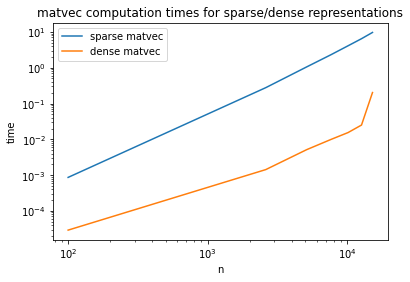

In [5]:
plt.figure()
plt.plot(ns, ts_sparse, label='sparse matvec')
plt.plot(ns, ts_dense, label='dense matvec')
plt.legend(loc='best')
plt.xlabel('n')
plt.ylabel('time')
plt.title('matvec computation times for sparse/dense representations')
plt.xscale("log"); plt.yscale("log")
plt.show();

**Comments on sparse / dense matvec performance**

The plot shows that the sparse matrix-vector computation is exponential in matrix size n, but the exponent of the growth is constant. The dense matrix-vector computation is also exponential in matrix size (initially with a smaller exponent than the sparse computation), but the the exponent appears to increase with n and I expect the dense matvec performance to be slower than the sparse representation for even higher n.

In [6]:
### generate a sparse positive-definite matrix that can be used by both GMRES and CG solvers ###

n = 300
Q, _ = np.linalg.qr(sps.random(n, n).todense()) # left matrix of a QR decomposition is guaranteed to be positive-definite
D = np.diag(np.random.randn(n) + 5) # the shifted diagonal means that the eigenvalues aren't centred on 0
A = Q.T @ D @ Q
A_coo = sps.coo_matrix(A)
b = np.random.randn(n, 1)
A_csr = CSRMatrix(A_coo)
print(f'matrix size: {n} x {n}')

matrix size: 300 x 300


Convergence? True


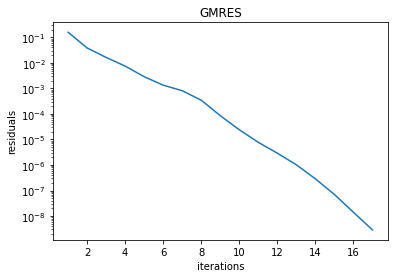

In [7]:
callback = lambda res: residuals.append(res)
residuals = []
x_gmres, exitcode = gmres(A_csr, b, callback=callback, callback_type = 'pr_norm', tol=1e-08)
print('Convergence?', exitcode==0)
plt.figure()
plt.plot(1 + np.arange(len(residuals)), residuals)
plt.yscale("log")
plt.ylabel('residuals')
plt.xlabel('iterations')
plt.title('GMRES')
plt.show()

Convergence? True


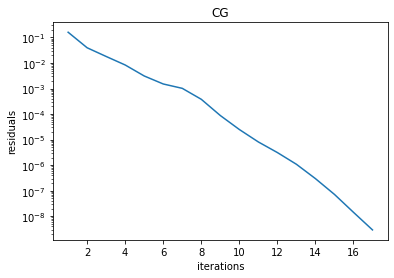

In [8]:
callback = lambda x: residuals.append(np.linalg.norm(b - A_csr._matvec(x)) / np.linalg.norm(b))
residuals = []
x_cg, exitcode = cg(A_csr, b, callback=callback, tol=1e-08)
print('Convergence?', exitcode==0)
plt.figure()
plt.plot(1 + np.arange(len(residuals)), residuals)
plt.yscale("log")
plt.xlabel('iterations')
plt.ylabel('residuals')
plt.title('CG')
plt.show()

In [9]:
# compare the solutions
if np.allclose(x_cg, x_gmres):
    print('solutions are the same (within rtol=1e-05)')
else:
    print('solutions are not the same')

solutions are the same (within rtol=1e-05)


**Comments on solutions**

The solutions are the same because I have chosen a matrix that is easy to solve for both GMRES and CG. For example, if I had chosen a matrix with eigenvalues that were centred on zero then GMRES would have struggled to converge to the same solution as CG.

## Part 2:

A is a 2n by 2n matrix with the following structure:
- The top left n x n block of A is a diagonal matrix
- The top right n x n block of A is zero
- The bottom left n x n block of A is zero
- The bottom right n x n block of A is dense but can be written as B = TW, where shape(T) = (n, 2) and shape(W) = (2,n)

In this section, I implement a Scipy LinearOperator for matrices of this form.

In [10]:
def dense_blockmat(n):
    '''
    returns dense matrix representation of 2n x 2n block matrix A
    '''
    D = np.diag(np.random.randn(n)) # diagonal block
    Z = np.zeros((n,n)) # zero blocks
    T = np.random.randn(n, 2) # tall matrix
    W = np.random.randn(2, n) # wide matrix
    Atilde = T@W # dense block
    return np.block([[D, Z], [Z, Atilde]])

def data_blockmat(A):
    '''
    returns the non-zero elements of 2n x 2n block matrix A as a list
    '''
    return A.ravel()[np.flatnonzero(A)]

In [11]:
class BlockMat(LinearOperator):
    def __init__(self, data):
        self.data = data # the position of the data is already known, so we only need to store the data
        # find n using the quadratic equation (since we know that n**2 + n = len(data))
        self.n = int(-1/2 + np.sqrt(1 + 4*len(data))/2)
        self.shape = (2*self.n, 2*self.n)
        self.dtype = data.dtype
        self.denseblock = np.array(self.data[self.n:]).reshape(self.n, self.n)
    
    def _matvec(self, vector):
        """Compute a matrix-vector product."""
        mv = np.zeros((self.shape[0]), dtype=np.float64)
        mv[:self.n] = np.array(self.data[:self.n]) * np.array(vector[:self.n]).T # diagonal elements
        mv[self.n:] = (self.denseblock @ vector[self.n:]).T # dense block elements Atilde
        return mv.reshape(self.shape[0], 1)
            

In [12]:
### testing matvec ###
n = 100
A_dense = dense_blockmat(n)
# print(A_dense)
data = data_blockmat(A_dense)
A = BlockMat(data)
# print(A_dense @ vector, '\n', A._matvec(vector))
vector = np.random.rand(2*n, 1)
assert np.allclose(A_dense @ vector, A._matvec(vector))
print('test passed')

test passed


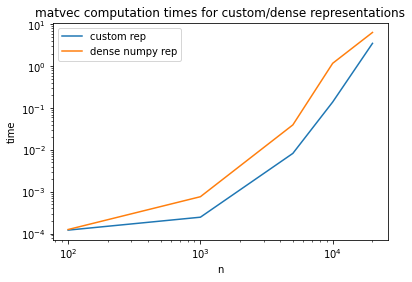

In [13]:
### timing matvec implementation ###
def f():
    A._matvec(vector)
def g():
    A_dense @ vector
    
ns = [100, 1000, 5000, 10000, 20000]
ts_custom = []
ts_numpy = []
for n in ns:
    vector = np.random.rand(2*n, 1)
    A_dense = dense_blockmat(n) # numpy representation
    data = data_blockmat(A_dense)
    A = BlockMat(data)
    ts_custom.append(timeit(f, number=1))
    ts_numpy.append(timeit(g, number=1))
    
plt.figure()
plt.plot(ns, ts_custom, label='custom rep')
plt.plot(ns, ts_numpy, label='dense numpy rep')
plt.legend(loc='best')
plt.xlabel('n')
plt.ylabel('time')
plt.title('matvec computation times for custom/dense representations')
plt.xscale("log"); plt.yscale("log")
plt.show();

**Comments on performance**

My implementation is faster than the dense numpy matvec product for all n. This is because my implementation multiplies two numpy arrays to compute the first n entries of the matvec product, and uses numpy matvec product for the last n entries. This has the benefit of using numpy throughout the computation while still reducing the total number of computations. 